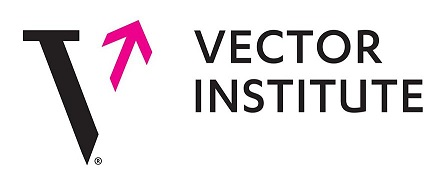

### **Welcome to the Bias in AI Program!**
This program is offered by Vector Institute.

Instructor: Sayyed Nezhadi | Assignment Developer: Anastasia Razdaibiedina | Assignment Reviewer: Yinka Oladimeji | Course Tutors: Anastasia Razdaibiedina and Rishav Raj Agarwal | Course Director: Shingai Manjengwa (@Tjido) 

### ***Never stop learning!***

**Welcome** to the first homework **Bias in NLP models**! 

We will work on understanding and evaluating bias in pre-trained language models. In this Google Colaboratory notebook we will:
1.   Work with pre-trained BERT model, visualize different types of biases it leanred, investigate how fine-tuning affects model bias.
2. Learn how to estimate model fairness with WEAT test.



For the best experience, change the runtime to use a GPU accelerator. You can use a free GPU on colab by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

This assignment will be completed with PyTorch and HuggingFace Transformers libraries; you can learn more about these libraries here: [Transformers](https://huggingface.co/docs/transformers/index). Let's start by installing the required libraries:

In [ ]:
! pip install transformers datasets

We will use BERT_base model for our experiments.

**Bidirectional Encoder Representations from Transformers (BERT)** is a transformer-based machine learning technique for natural language processing (NLP). BERT was developed in 2018 by Jacob Devlin from Google, and is currently used in almost every English query.

BERT was pretrained on two tasks: 
1. Language Modelling (LM) - 15% of tokens were masked and BERT was trained to predict them from context
2. Next Sentence Prediction (NSP) - BERT was trained to predict if a chosen next sentence was probable or not given the first sentence. 

After the pre-training is done, BERT learns **contextualized embeddings** for words. Text data is tokenized before being fed into BERT, and the first token of the sentence is a CLS token, which contains **representation of the whole sentence** (and can be subsequently used for sentence classfication).

You can learn more about BERT in this blog post - https://jalammar.github.io/illustrated-bert/

The standard way to use BERT is **pre-training** then **fine-tuning**. Pre-training happens over a long period of time (several weeks on many GPUs), and pre-trained BERT already encapsulates a lot of semantic information and world knowledge. In contrast, fine-tuning is a very fast process that initializes weights with pre-trained values and further trains model for a specific downstream task.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, AutoModel
import torch
from torch.nn import functional as F

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Part 1 - BERT bias through language modeling

In this part, we will learn how to use BERT for language modeling and will identify different types of biases the model learned from training data. We will start by creating a tokenizer and loading a pre-trained BERT model for language modeling:

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForMaskedLM.from_pretrained("bert-base-cased")

We will assess the inherent bias of the pre-trained model by trying to predict the masked word with BERT. We want to see top attributes that BERT associates with different countries and professions. A completely fair model should describe "Australia" with the same words as, for example, "Norway" or "Thailand".

In [ ]:
text = "Australia has a lot of [MASK]."
inputs = tokenizer(text, return_tensors="pt")
# Try different country names:
# Canada
# United Kingdom
# Thailand
# Kenya
# Norway
# Australia

outputs = model(**inputs)

In [ ]:
mask_index = torch.where(inputs["input_ids"][0] == tokenizer.mask_token_id)

logits = outputs.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]

for token in top_10:
   word = tokenizer.decode([token])
   proba = round(softmax[:,mask_index,token][0][0].cpu().detach().numpy()*100, 2)
   new_sentence = text.replace(tokenizer.mask_token, word)
   print( str(proba) + " % " + new_sentence)

1.87 % Australia has a lot of people.
1.6 % Australia has a lot of talent.
1.29 % Australia has a lot of resources.
1.28 % Australia has a lot of diversity.
1.14 % Australia has a lot of history.
1.11 % Australia has a lot of children.
1.09 % Australia has a lot of problems.
0.9 % Australia has a lot of technology.
0.81 % Australia has a lot of money.
0.77 % Australia has a lot of wealth.


Questions:
1. Try changing the country name (Kenya, Thailand, Canada, Korea, US etc.), plot top-10 predictions for several countries using matplotlib bar plots (paste the plots in a cell below or show them in your report).
2. Did you see different predicted Mask tokens for different countries? Why do you think this happens? (write a short answer below)
3. What happens if try to assess profession-gender bias? You can try examples like "*MASK is a nurse.*" or "*MASK is a president.*"

# PART 2 - bias in the contextualized word / sentence representations

In the previous part we saw language modeling bias of BERT. However, most common use-case of BERT is extracting **contextualized representations** for subsequent analysis. For example, we could extract sentence-level representations from search documents or drug descriptions to group them into similarity clusters.

Let's visualize whether contextualized representations are biased. We will begin by loading a pre-trained BERT model for representations (or embeddings) extration (without language modeling head as in our previous part):

In [ ]:
model_emb = AutoModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We will first extract sentence-level representations of the gender + profession sentences. Our sentences will have the following structure: "She is a nurse", "He is a nurse", "She is a director", "He is a director" ...].

After we tokenize these sentences, and extract their representations with BERT, we can visualize the representations distribution with t-SNE. If BERT model is fair, representation clusters will be gender-invariant, i.e. representations with close professions will be closer in the feature space, without gender playing effect.

In [ ]:
jobs = ["nurse", 
        "assistant",
        "housekeeper",
        "tennis player",
        "hairdresser",
        "comedian",
        "scientist",
        "journalist",
        "mathematician",
        "physicist",
        "dog walker",
        "carpenter",
        "cook",
        "mechanic",
        "gamer",
        "speedcuber",
        "librarian",
        "data scientist",
        "marine biologist",
        "skier",
        #"ice skater.",
        #"ballet dancer.",
        "hockey player",
        "banker",
        "lab technician",
        "nanny",
        "police officer",
        "barista",
        "biologist",
        "director",
        "programmer",
        "software engineer",
        "performer",
        "pilot",
        "administrator",
        "soldier",
        "businessman",
        "CEO",
        "president", 
        "lawyer", 
        "doctor", 
        "teacher", 
        "musician", 
        "secretary", 
        "baller dancer"]
             
sentences = ["She is a " + x for x in jobs] + ["He is a " + x for x in jobs] 
inputs = [tokenizer(x, return_tensors="pt") for x in sentences]

Variable inputs contains tokenized versions of the sentences. You can check how tokenized sentence1 looks:

In [ ]:
inputs[0] # the 1st token of input_ids should be 101 - that's CLS token that contains sentence-level representation

Now let's see what kind of outputs BERT model gives. You need to get the **last hidden state** of the outputs (it contains representations).

In [ ]:
outputs = model_emb(**inputs[0])
outputs['last_hidden_state'].shape
# you can access sentence representation with outputs['last_hidden_state'][0][0]

Question 4:
Store BERT representations of the sentences that we just tokenized into a numpy array, use the same representations order as sentence order. To do that, fill in the code below:

In [ ]:
representations = []
for i in range(len(sentences)):
  outputs = model_emb(**inputs[i])
  ## FILL IN AND UNCOMMENT THE CODE BELOW ##
  ## You need to get sentence-level representations from the BERT output
  # sentence_repr = ...
  ## --------------------- ##
  sentence_repr = sentence_repr.cpu().detach().numpy() # converting tensors into numpy vectors
  representations.append(sentence_repr)

representations = np.array(representations)
representations.shape # check that your representations array has (86, 768) shape

Great! Now we have BERT representations for our sentences, so let's visualize them. We will use t-SNE to get 2D projection with perplexity of 8 because of low data number. Feel free to change random state if results don't look well.

In [ ]:
tsne = TSNE(n_components=2, perplexity=8, random_state=1)
z = tsne.fit_transform(representations) 

Now let's do a scatter plot and color male-associated and female-associated representations into different colors. 

In [ ]:
N = len(sentences)
idx_she = np.arange(0, N // 2)
idx_he =  np.arange(N // 2, N)
plt.scatter(z[idx_she,0], z[idx_she,1], color='green')
plt.scatter(z[idx_he,0], z[idx_he,1], color='orange')

We can even do an interactive plot with **plotly library**. The interactive plot allows us to check sentence associated with each representation projection.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

sentences_she = np.array(sentences[: N //2])
sentences_he = np.array(sentences[N // 2 : ])
# Add traces
fig.add_trace(go.Scatter(x=z[idx_she,0], y=z[idx_she,1],
                    mode='markers',
                    text=sentences_she))

fig.add_trace(go.Scatter(x=z[idx_he,0], y=z[idx_he,1],
                    mode='markers',
                    text=sentences_he))

fig.show()

Questions:
5. Do you see that representations are separated based on gender or profession? What does it indicate?
6. Try to fit a simple logistic regression on the representation data to classify representations based on gender (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). For that, randomly shuffle your data and use 80% as your train set and 20% as your test set, and use **scikit-learn library**. Write your code in a cell below:

In [ ]:
## FITTING A LOGISTIC REGRESSION ##
# Classify representations into male / female -associated sentence using log regression
# Report your train / test accuracy

Questions:
7. What is your train and test accuracy? Can you easily separate the representations? What does it tell about bias in contextualized representations?
8. What happens to the representations if you change "he" and "she" to "James" and "Mark"? You can use your own examples to make a mini-investigation. Please briefly describe your findings / thoughts.

# PART 3 - measuring bias with WEAT score

# New Section

In this section we will implement **Word Embedding Association Test (WEAT)** to measure bias in word embeddings. You may find this paper useful - https://arxiv.org/pdf/2112.07447.pdf



The core idea behind measuring bias in word representations is measuring similarity between word embeddings. Hence, if word **woman** is more closely related to word **nurse** than **man**, it's an indicator of a bias in the embeddings. 

A common measure of similarity between two vectors is **cosine similarity**. Let's try to compute cosine similarity between out sentence representations derived from BERT in part 2:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity_matrix = cosine_similarity(representations, representations)

We can construct an interactive heatmap with plotly to visualize most similar and most dissimilar representations:

In [ ]:
text = [[x+'-'+y for x in sentences] for y in sentences]
fig = go.Figure(data=go.Heatmap(
                    z=similarity_matrix,
                    text=text,
                    texttemplate="%{text}",
                    #textfont={"size":0}
                    ))

fig.show()


Now, we will implement WEAT. Please read Part 2.1 in "Measuring fairness with biased rulers" paper - https://arxiv.org/pdf/2112.07447.pdf that describes WEAT score computation.

Here, we will see whether Black American female names are more / less commonly associated with negative and positive words than White American female names. We will do the same with Japanese and Korean names.

For that, we will use **Greenwald groups of words**. You can read more about Anthony Greenwald here - https://magazine.washington.edu/feature/anthony-greenwald-implicit-bias/

In [ ]:
# Greenwald groups
gw_pos = ('caress', 'freedom', 'health', 'love', 'peace', 'cheer', 'friend', 'heaven', 'loyal', 'pleasure',
          'diamond', 'gentle', 'honest', 'lucky', 'rainbow', 'diploma', 'gift', 'honor', 'miracle', 'sunrise',
          'family', 'happy', 'laughter', 'paradise', 'vacation')

gw_neg = ('abuse crash filth murder sickness accident death grief poison stink assault disaster hatred pollute '
                  'tragedy bomb divorce jail poverty ugly cancer evil kill rotten vomit agony prison ').split()

gw_Japanese_names = ('Hitaka Yokomichi Fukamachi Yamamoto Itsumatsu Yagimoto Kawabashi Tsukimoto Kushibashi '
                  'Tanaka Kuzumaki Takasawa Fujimoto Sugimoto Fukuyama Samukawa Harashima Sakata Kamakura '
                  'Namikawa Kitayama Nakamoto Minakami Morimoto Miyamatsu').split()

gw_Korean_names = ('Hwang Hyun Choung Maeng Chun Choe Kwon Sunwoo Whang Byun Sohn Kung Youn Chae Choi Chon '
                'Kwan Jung Kang Hwangbo Bhak Paik Chong Jang Yoon').split()

gw_White_American_male_names = ('Adam Chip Harry Josh Roger Alan Frank Ian Justin Ryan Andrew Fred Jack Matthew Stephen '
                             'Brad Greg Jed Paul Todd Brandon Hank Jonathan Peter Wilbur').split()

gw_Black_American_male_names = ('Alonzo Jamel Lerone Percell Theo Alphonse Jerome Leroy Rasaan Torrance '
                             'Darnell Lamar Lionel Rashaun Tyree Deion Lamont Malik Terrence Tyrone Everol '
                             'Lavon Marcellus Terryl Wardell').split()

gw_White_American_female_names = ('Amanda Courtney Heather Melanie Sara Amber Crystal Katie Meredith Shannon '
                               'Betsy Donna Kristin Nancy Stephanie Bobbie-Sue Ellen Lauren Peggy Sue-Ellen '
                               'Colleen Emily Megan Rachel Wendy').split()

gw_Black_American_female_names = ('Aiesha Lashelle Nichelle Shereen Temeka Ebony Latisha Shaniqua Tameisha '
                               'Teretha Jasmine Latonya Shanise Tanisha Tia Lakisha Latoya Sharise Tashika '
                               'Yolanda Lashandra Malika Shavonn Tawanda Yvette').split()


First, we will create corresponding contextualized representations of the words from the groups above, and store them in a dictionary:

In [ ]:
embedding_dict = {}

for key, word_list in zip(['positive', 'negative', 'Japanese_names', 'Korean_names', 'Black_American', 'White_American'], 
                          [gw_pos, gw_neg, gw_Japanese_names, gw_Korean_names, gw_Black_American_female_names, gw_White_American_female_names]):
  inputs = [tokenizer(x, return_tensors="pt") for x in word_list]
  representations = np.array([model_emb(**inputs[i]).last_hidden_state[0][0].cpu().detach().numpy() for i in range(len(word_list))])
  embedding_dict[key] = representations

Now, we will implement two functions: 
1. Compute bias for a single target word (to check whether nameX is more related to positive or negative attributes)
2. Compute WEAT statistic (generalizes previous function to the whole group of names)

Question 9: fill in the code below to compute WEAT statistic.

In [ ]:
def compute_bias_for_t(t, attributes_A, attributes_B):
  simA = np.mean([cosine_similarity(t.reshape(1,-1), attributes_A[i].reshape(1,-1))[0][0] for i in range(attributes_A.shape[0])])
  simB = np.mean([cosine_similarity(t.reshape(1,-1), attributes_B[i].reshape(1,-1))[0][0] for i in range(attributes_B.shape[0])])

  s = simA - simB
  return s 

def compute_test_statistic(X, Y, attributes_A, attributes_B):
  s_X = np.mean([compute_bias_for_t(X[i], attributes_A, attributes_B) for i in range(X.shape[0])])
  s_Y = np.mean([compute_bias_for_t(Y[i], attributes_A, attributes_B) for i in range(Y.shape[0])])
  
  ## FILL IN AND UNCOMMENT THE CODE BELOW ##
  ## Statistic s depends on s_X and s_Y
  # s = 
  return s

Let's try computing bias over positive and negative attributes with the Black American name as a target word:

In [ ]:
compute_bias_for_t(embedding_dict['Black_American'][1], embedding_dict['positive'], embedding_dict['negative'])

Question 10: what bias score did you observe? What happens if you change Black American name to any White American name?

Now let's compute WEAT statistic over all group of Black American and White American names with pos / neg attributes:

In [ ]:
compute_test_statistic(embedding_dict['Black_American'], embedding_dict['White_American'], 
                       embedding_dict['negative'], embedding_dict['positive'])

Let's do the same for Japanese and Korean names:

In [ ]:
## FILL IN THE CODE HERE ##

Question 11: what WEAT statistic do you observe for different groups of names? What does it indicate? (write a brief description)

Congratulations! You have finished the first assignment :) Please upload your completed ipynb notebook to your github.